# Data generation

## Initial setup

Here, the necessary libraries are being setup

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.7.1" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.7.1 on the current Colab Runtime...
2022-03-30 11:24:48 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.7/julia-1.7.1-linux-x86_64.tar.gz [123374573/123374573] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing Julia package Plots...
Installing Julia package CUDA...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.7

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


In [6]:
pip install julia

     |████████████████████████████████| 67 kB 4.0 MB/s 


In [7]:
import julia as jl
jl.install()


Precompiling PyCall...
Precompiling PyCall... DONE
PyCall is installed and built successfully.


The emulator is aimed at providing in-silico data to test some of the machine learning tool discussed during the course.
The emulator is mimicking the behavior of a fed-batch cell culture process, where only few components are present:
- The cells, responsible for the production of the product, which are consuming glucose to sustain metabolism and producing lactate as by-product. These are indicated by VCD (viable cell density), typically expressed in million cells / ml.
- Glucose (Glc) is consumed by the cells and it is continuously fed to the process (F_glc). Too low glucose concentrations are slowing down cell growth and product production. To high glucose concentrations are poisoning the system and accelerating cell death.
- Lactate (Lac) is a by-product of the cells and it is poisoning the cells, so that too high lactate concentrations are slowing down cell metabolism and accelerating cell death
- Product (Prod) is produced by the cells. The faster the cells are growing, the less are producing the product. 

## Model Equations

The emulator's results are based on the following equations to create the in-sillico data

- Balance on VCD:  $\frac{dVCD}{dt}$ = (μ<sub>g</sub> - μ<sub>d</sub>)VCD
- Balance on Glucose: $\frac{dGlc}{dt}$ = $-k_{Glc} \frac{Glc}{Glc + 0.05}$VCD + F<sub>Glc</sub>
- Balance on Lactate: $\frac{dLac}{dt}$ = k<sub>Lac</sub> VCD
- Balance on Product: $\frac{dProd}{dt}$ = k<sub>Prod</sub>$\frac{Glc}{Glc + K_{g, Glc} }$ ($\frac{μ_{g}}{μ_{g,max}}$)<sup>2</sup>VCD

Where:
- Growth rate: $μ_{g} =  μ_{g,max}\frac{Glc}{Glc +K_{g, Glc}}\frac{K_{i, Lac}}{Lac+K_{i, Lac}} $
- Death rate: $μ_{d} = μ_{d,max}(1+\frac{φ}{1+φ})\frac{Lac}{Lac+K_{d, Lac}}$
- Glc saturation: φ = e<sup>0.1(Glc-75)</sup>

$\frac{}{}$

## Parameter selection

The emulator will simulate a predefined number of experiments. The results of those experiments is based on the   intervals of the desired parameters (from initial conditions to the number of experiments). These experiments will then be used to create the dataset that will be used in the subsequent sections of the code. You will have the opportunity to define those ranges in the sections below.

### Parameters' ranges

Define the value range of the maximum growth rate interval $μ_{g,max}$

In [8]:
mu_g_max = [0.01, 0.10]

Define the value range of the maximum death rate interval $μ_{d,max}$

In [9]:
mu_d_max = [0.025, 0.075]

Define the value range of the $K_{g,Glc}$

In [10]:
K_g_Glc = [1, 2]

Define the value range of the $K_{g,Lac}$

In [11]:
K_g_Lac = [50, 80]

Define the value range of the $K_{I,Lac}$

In [12]:
K_I_Lac = [30, 50]

Define the value range of the $K_{d,Lac}$

In [13]:
K_d_Lac = [50, 80]

Define the value range of the $k_{Glc}$

In [14]:
k_Glc = [0.04, 0.12]

Define the value range of the $k_{Lac}$

In [15]:
k_Lac = [0.06, 0.15]

Define the value range of the $k_{prod}$

In [16]:
k_Prod = [1, 3]

Define the value range of the days at which Glc feed is started

In [17]:
feed_start = [3, 6]

Define the value range of the days at which Glc feed is ended

In [18]:
feed_end = [12.0, 16]

Define the Glc feed rate

In [19]:
Glc_feed_rate = [12.0, 15.0]

Define the initial glucose feed values ranges

In [20]:
Glc_0 = [12.0, 15.0]

Define the initial VCD value ranges

In [21]:
VCD_0 = [0.3, 0.6]

Define the number of experiments to be generated in the simulator

In [22]:
num_exp = 20

In [23]:
#data generation parameters
import pandas as pd

# format is variable = [lower bound, upper bound]
mu_g_max = [0.01, 0.10]
mu_d_max = [0.025, 0.075]
K_g_Glc = [1, 2]
K_g_Lac = [50, 80]
K_I_Lac = [30, 50]
K_d_Lac = [50, 80]
k_Glc = [0.04, 0.12]
k_Lac = [0.06, 0.15]
k_Prod = [1, 3]
feed_start = [3, 6]
feed_end = [12.0, 16]
Glc_feed_rate = [12.0, 15.0]
Glc_0 = [12.0, 15.0]
VCD_0 = [0.3, 0.6]

num_exp = 20




Here, an aggregation of the generated data is shown in table form

In [24]:
from julia.api import Julia
j = Julia(compiled_modules=False)
j = jl.Julia()

from julia import Main
Main.eval('using Pkg; Pkg.add("DifferentialEquations"); Pkg.add("Plots"); Pkg.add("Plots"); Pkg.add("DataFrames"); Pkg.add("CSV"); Pkg.add("LatinHypercubeSampling")')

In [25]:

generate_data =j.include("test.jl") #the generated data is saved into 'mytable.csv' in the same directory as this notebook

var_lims = {"mu_g_max":mu_g_max,
    "mu_d_max": mu_d_max,
    "K_g_Glc" : K_g_Glc,
    "K_g_Lac" : K_g_Lac,
    "K_I_Lac" : K_I_Lac,
    "K_d_Lac" : K_d_Lac,
    "k_Glc" : k_Glc,
    "k_Lac" : k_Lac,
    "k_Prod" : k_Prod,
    "feed_start" : feed_start,
    "feed_end" : feed_end,
    "Glc_feed_rate" : Glc_feed_rate,
    "Glc_0" : Glc_0,
    "VCD_0" : VCD_0}


# Use the function to generate data
data = generate_data(var_lims, num_exp)
data

/usr/local/lib/python3.7/dist-packages/julia/core.py:707: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  FutureWarning,


<PyCall.jlwrap 300×5 DataFrame
 Row │ timestamps  X:VCD         X:Glc         X:Lac     X:Titer
     │ Float64     Float64       Float64       Float64   Float64
─────┼───────────────────────────────────────────────────────────────
   1 │        0.0  15.0          13.2353         0.0     0.0
   2 │        1.0  11.0323       -2.55413e-5    15.9952  0.000738488
   3 │        2.0   5.86972      -7.77355e-5    25.846   0.000743119
   4 │        3.0   2.77783       0.00412792    30.775   0.0125808
   5 │        4.0   1.25667       0.00996714    33.0542  0.0278367
   6 │        5.0   0.557756      0.00013197    34.0764  0.0378292
   7 │        6.0   0.244337     -0.00012368    34.5269  0.0378295
   8 │        7.0   0.106642      0.000158612   34.7239  0.0378295
   9 │        8.0   0.0464702    -0.000153649   34.8098  0.0378296
  10 │        9.0   0.0202357    -0.000151801   34.8472  0.0378296
  11 │       10.0   0.00880907   -8.77963e-5    34.8635  0.0378296
  12 │       11.0   0.00383428    

Alternatively, you can run the simulator to obtain one singular experiment by defining the variable values

In [26]:
generate_data =j.include("test_one_exp.jl") #the generated data is saved into 'mytable.csv' in the same directory as this notebook

mu_g_max = 0.01
mu_d_max = 0.025
K_g_Glc = 1
K_g_Lac = 50
K_I_Lac = 30
K_d_Lac = 50
k_Glc = 0.04
k_Lac = 0.06
k_Prod = 1
feed_start = 3
feed_end = 12.0
Glc_feed_rate = 12.0
Glc_0 = 12.0
VCD_0 = 0.3

num_exp = 20


# Use the function to generate data
data = generate_data(feed_start, feed_end, Glc_feed_rate, Glc_0, VCD_0, mu_g_max, mu_d_max, K_g_Glc, K_I_Lac, K_d_Lac, k_Glc, k_Lac, k_Prod)
data

/usr/local/lib/python3.7/dist-packages/julia/core.py:707: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  FutureWarning,


<PyCall.jlwrap 15×5 DataFrame
 Row │ timestamps  X:VCD     X:Glc      X:Lac      X:Titer
     │ Float64     Float64   Float64    Float64    Float64
─────┼────────────────────────────────────────────────────────
   1 │        0.0  0.3         12.0      0.0        0.0
   2 │        1.0  0.372643    11.6795   0.482804   0.0540599
   3 │        2.0  0.457949    11.2835   1.0793     0.152189
   4 │        3.0  0.55563     10.807    1.80765    0.326888
   5 │        4.0  0.661556   298.214    2.68475    0.41949
   6 │        5.0  0.764492   585.529    3.71213    0.585826
   7 │        6.0  0.857691   872.749    4.88184    0.898339
   8 │        7.0  0.932195  1159.89     6.17332    1.42552
   9 │        8.0  0.980508  1446.97     7.55398    2.22899
  10 │        9.0  0.998178  1734.02     8.98245    3.34561
  11 │       10.0  0.984647  2021.06    10.4137     4.77383
  12 │       11.0  0.943075  2308.13    11.8047     6.47068
  13 │       12.0  0.879299  2593.43    13.119      8.36059
  14 │ 

## Construction of an OWU matrix from the generated data

For better visualisation of the in-sillico data, the data was reshaped into an OWU matrix. So, the values of each variable are separated by experiment.

In [27]:

import importlib  
import pandas as pd
transformations = importlib.import_module("drive.MyDrive.courses-notebooks.transformations")

owu = transformations.owu_from_csv("/content/mytable.csv")
pd.set_option('display.max_rows', None)

owu

X:VCD         X:Glc       X:Lac   X:Titer
run timestamps                                               
 0  0.0         15.000000  1.323529e+01    0.000000  0.000000
    1.0         11.032284 -2.554135e-05   15.995206  0.000738
    2.0          5.869720 -7.773554e-05   25.845981  0.000743
    3.0          2.777828  4.127921e-03   30.775010  0.012581
    4.0          1.256674  9.967136e-03   33.054174  0.027837
    5.0          0.557756  1.319699e-04   34.076355  0.037829
    6.0          0.244337 -1.236801e-04   34.526872  0.037829
    7.0          0.106642  1.586123e-04   34.723866  0.037830
    8.0          0.046470 -1.536490e-04   34.809776  0.037830
    9.0          0.020236 -1.518009e-04   34.847199  0.037830
    10.0         0.008809 -8.779633e-05   34.863493  0.037830
    11.0         0.003834  1.379541e-04   34.870585  0.037830
    12.0         0.001669 -7.042356e-05   34.873672  0.037830
    13.0         0.000726 -7.573525e-05   34.875016  0.037830
    14.0         0.000316 -2.923728e-05   34.875601  0.037830
 1  0.0         13.588235  1.429412e+01    0.000000  0.000000
    1.0          9.664021  1.465079e-05   22.502377  0.000665
    2.0          4.876141  2.963799e-03   35.749199  0.019135
    3.0          2.187264  6.671215e-03   42.034522  0.038401
    4.0          0.937166  1.339407e-04   44.790363  0.045605
    5.0          0.393910  7.388998e-05   45.959462  0.045605
    6.0          0.164351  1.355665e-04   46.449043  0.045605
    7.0          0.068364  1.151427e-04   46.653000  0.045605
    8.0          0.028401 -1.504123e-04   46.737785  0.045605
    9.0          0.011793  4.993336e-05   46.772999  0.045605
    10.0         0.004896  1.382526e-04   46.787619  0.045605
    11.0         0.002032 -6.350400e-05   46.793688  0.045605
    12.0         0.000843  7.516735e-05   46.796207  0.045605
    13.0         0.000350 -1.749256e-05   46.797253  0.045605
    14.0         0.000145 -4.221739e-06   46.797687  0.045605
 2  0.0         13.235294  1.270588e+01    0.000000  0.000000
    1.0         10.027923  5.605510e-05   26.447223  0.001088
    2.0          5.739502  1.690164e-04   43.594251  0.001095
    3.0          2.966120  3.220136e-03   52.894860  0.007032
    4.0          1.468597  8.388394e-05   57.597577  0.010031
    5.0          0.713264 -1.657763e-04   59.903346  0.010031
    6.0          0.343354 -1.653277e-04   61.018218  0.010032
    7.0          0.164596 -1.151835e-04   61.553777  0.010032
    8.0          0.078747 -1.649126e-04   61.810257  0.010032
    9.0          0.037639  1.408486e-04   61.932906  0.010032
    10.0         0.017983 -1.609370e-04   61.991516  0.010032
    11.0         0.008590 -4.853889e-05   62.019515  0.010032
    12.0         0.004102  7.948760e-05   62.032888  0.010032
    13.0         0.001959 -9.612383e-05   62.039275  0.010032
    14.0         0.000936  6.527298e-05   62.042326  0.010032
 3  0.0         14.647059  1.305882e+01    0.000000  0.000000
    1.0         11.108627  1.347357e-04   26.237361  0.000417
    2.0          6.572055  1.331673e-05   43.500846  0.000422
    3.0          3.591356  2.740548e-03   53.288402  0.012820
    4.0          1.899442 -1.643872e-04   58.548351  0.024803
    5.0          0.984448  1.099674e-04   61.302434  0.024803
    6.0          0.506280  7.447842e-05   62.724262  0.024804
    7.0          0.259366 -1.908691e-05   63.454062  0.024804
    8.0          0.132614  1.079576e-04   63.827572  0.024804
    9.0          0.067739 -8.268913e-06   64.018454  0.024804
    10.0         0.034583 -1.136610e-04   64.115931  0.024804
    11.0         0.017652  7.441010e-05   64.165691  0.024804
    12.0         0.009008 -1.228409e-04   64.191087  0.024804
    13.0         0.004597  9.188897e-05   64.204048  0.024804
    14.0         0.002346 -5.601994e-05   64.210661  0.024804
 4  0.0         12.705882  1.500000e+01    0.000000  0.000000
    1.0          8.407882  1.633941e-04   31.609808  0.000949
    2.0          3.978030  2.379821e-03   48.874580 

Furthermore, the evolution of each variable with respect to time is also visible here, but this time in the form of a graph

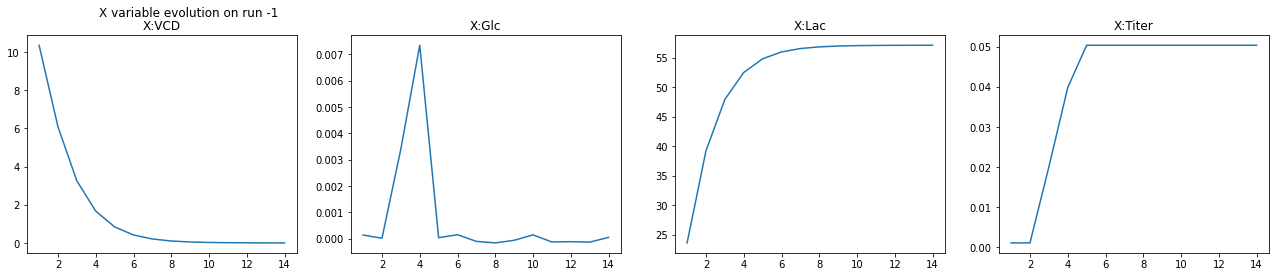

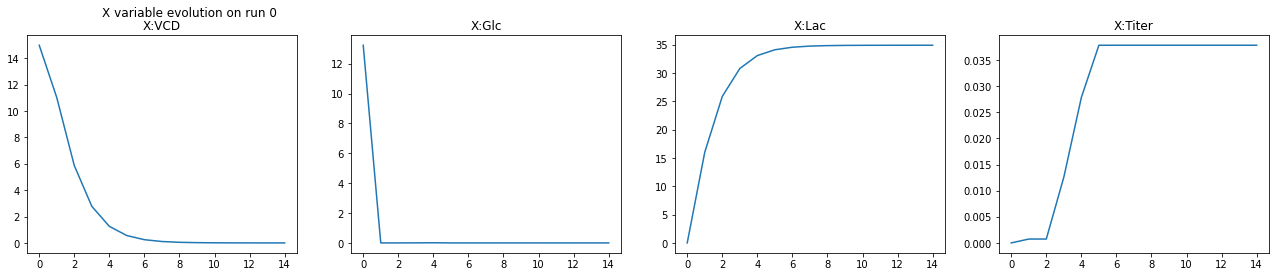

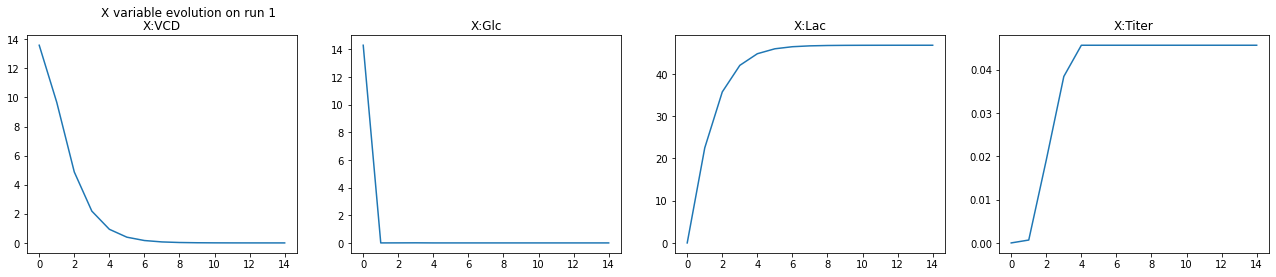

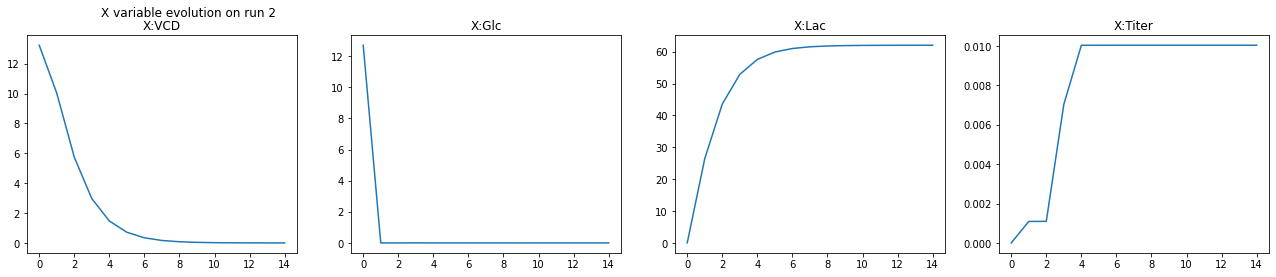

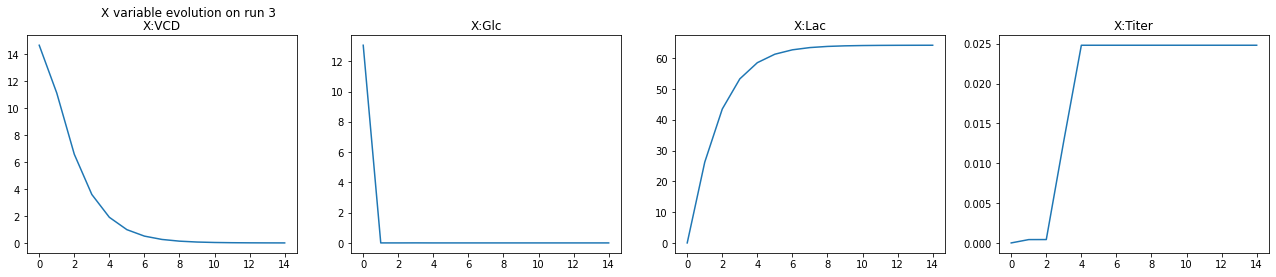

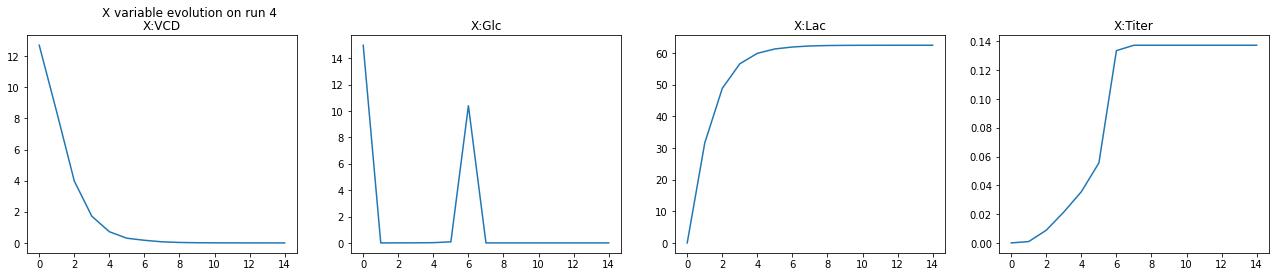

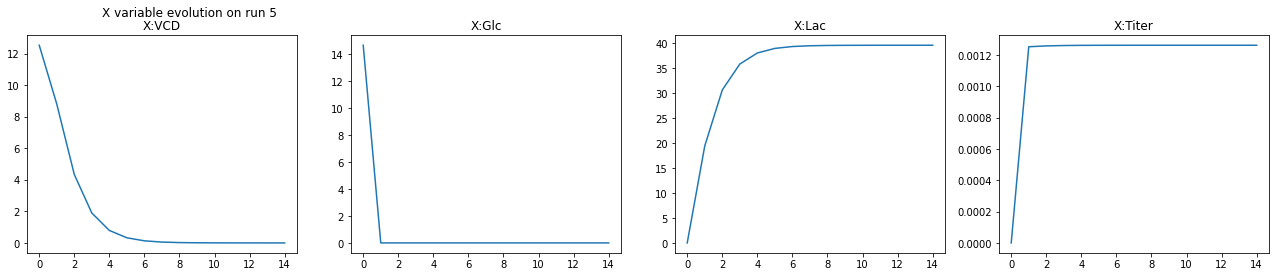

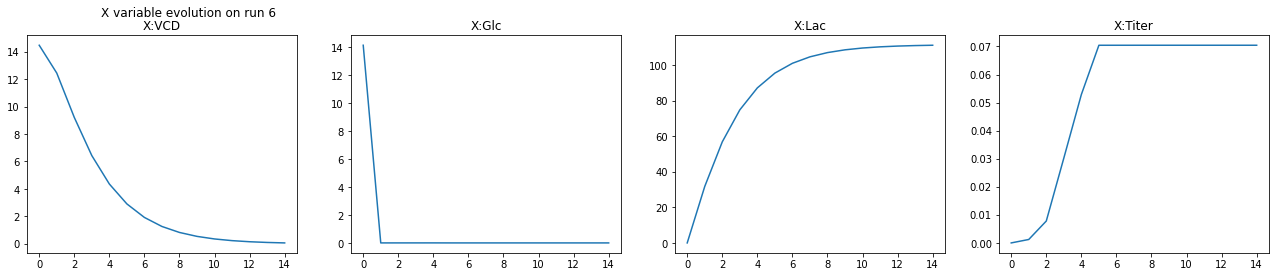

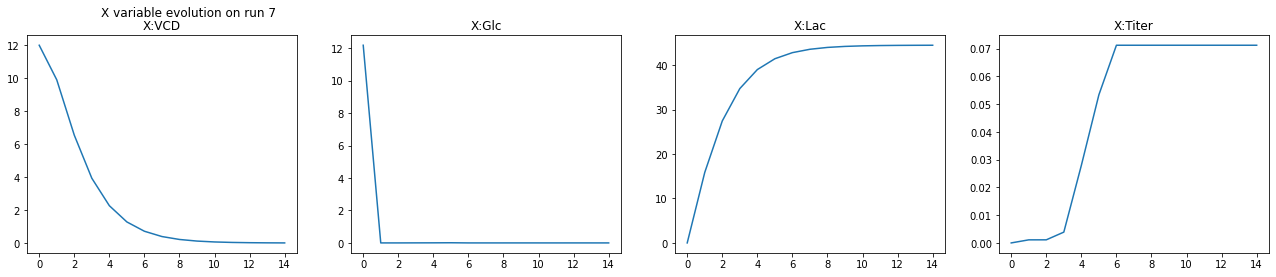

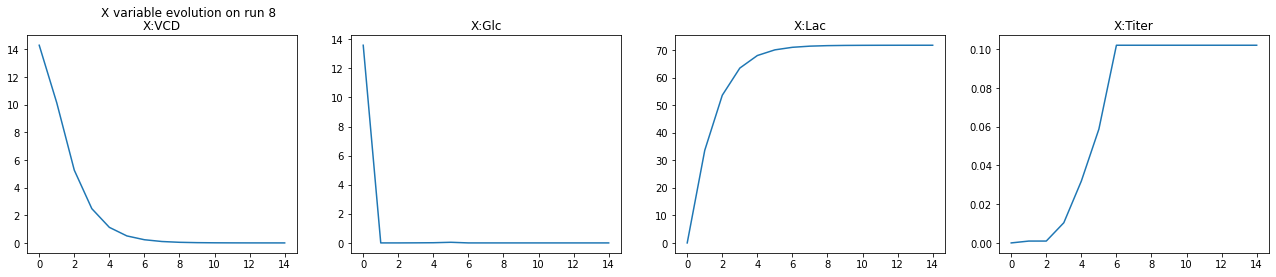

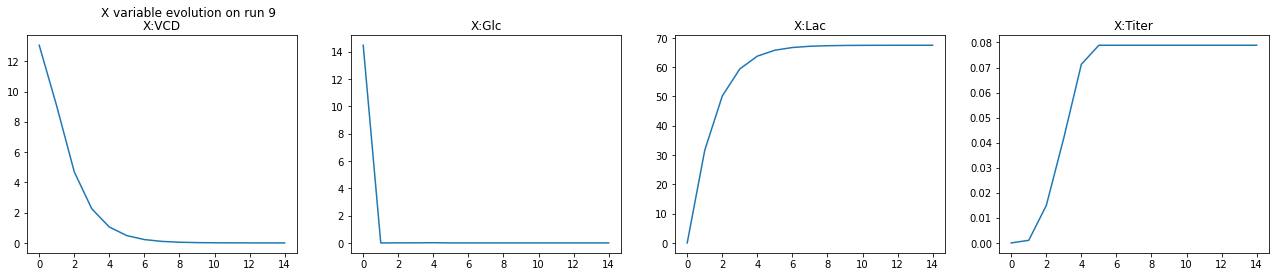

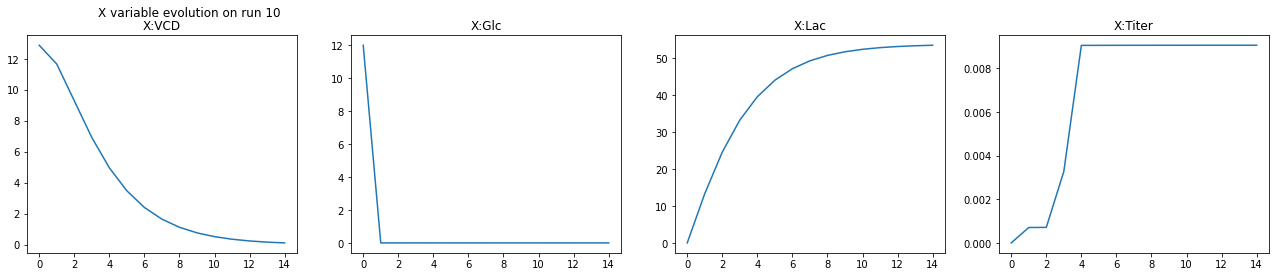

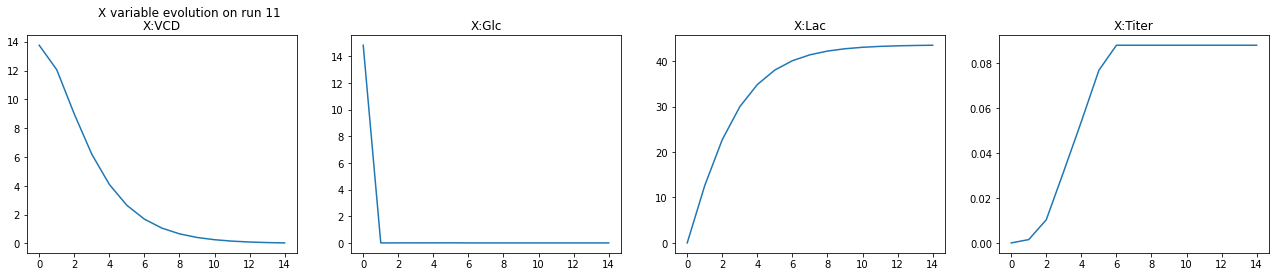

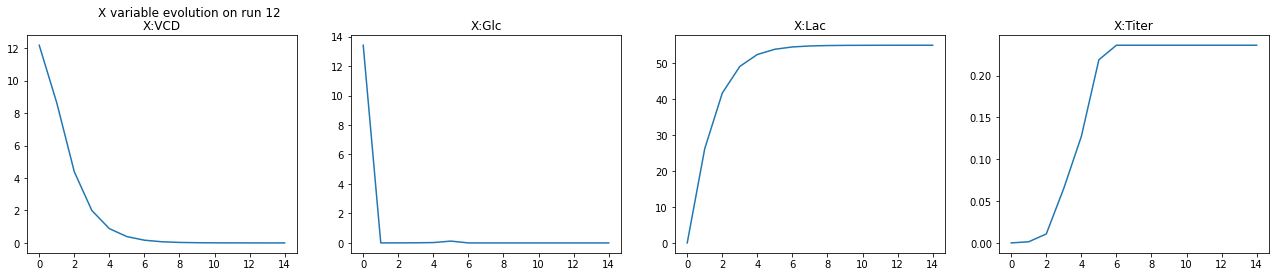

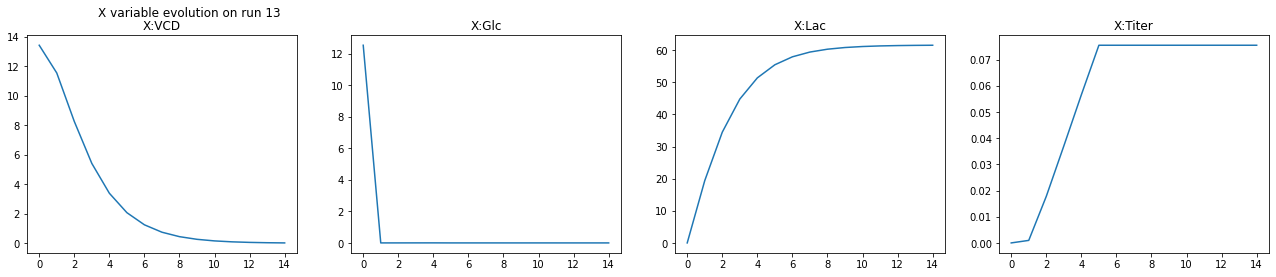

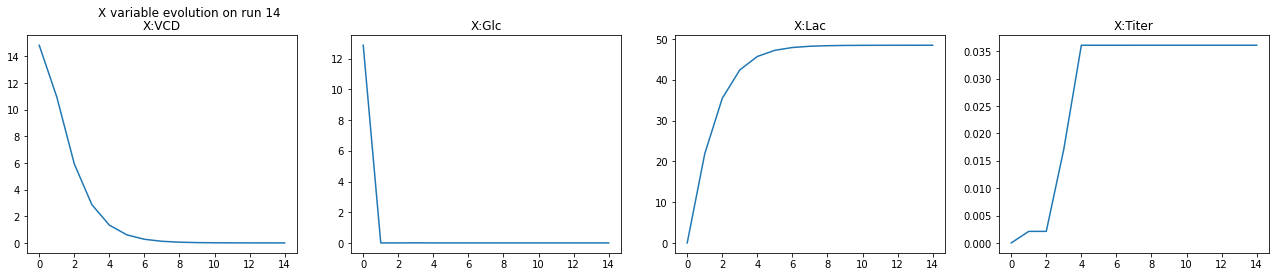

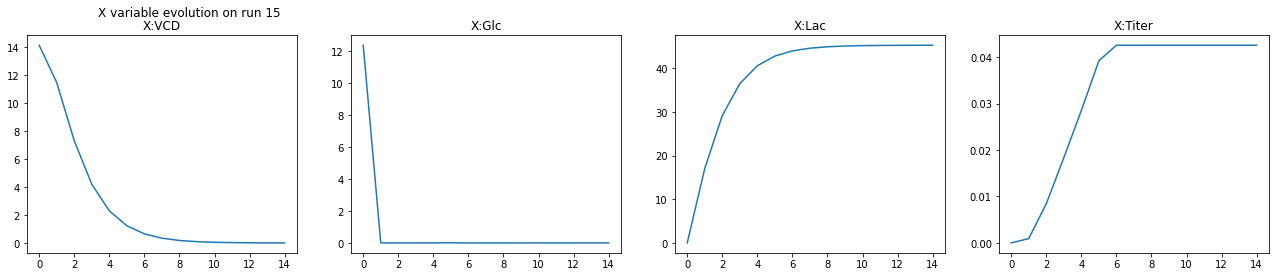

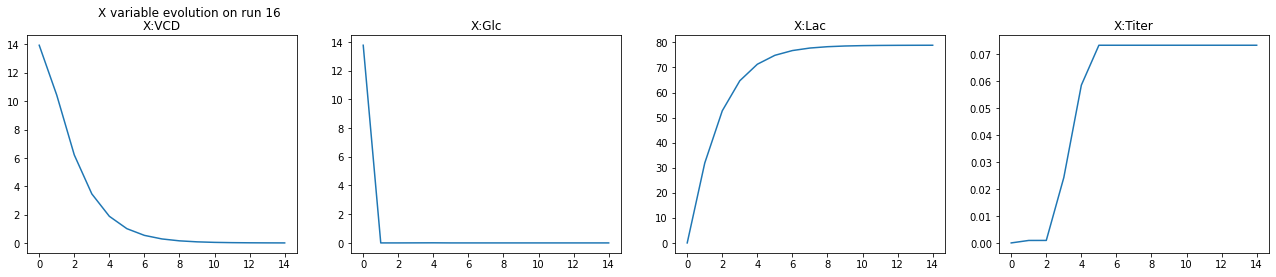

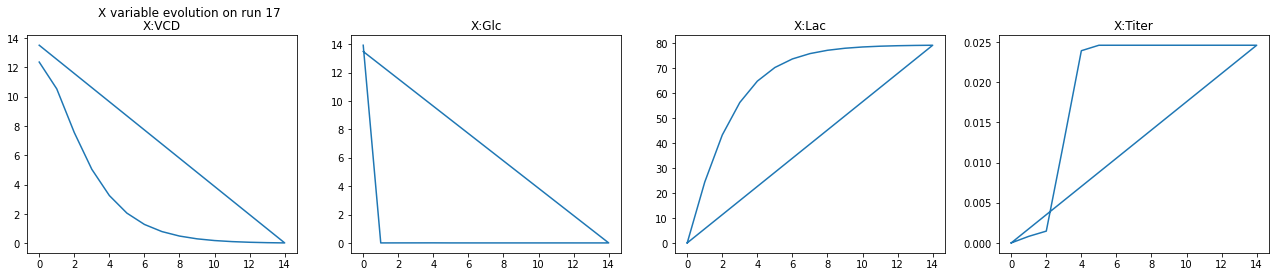

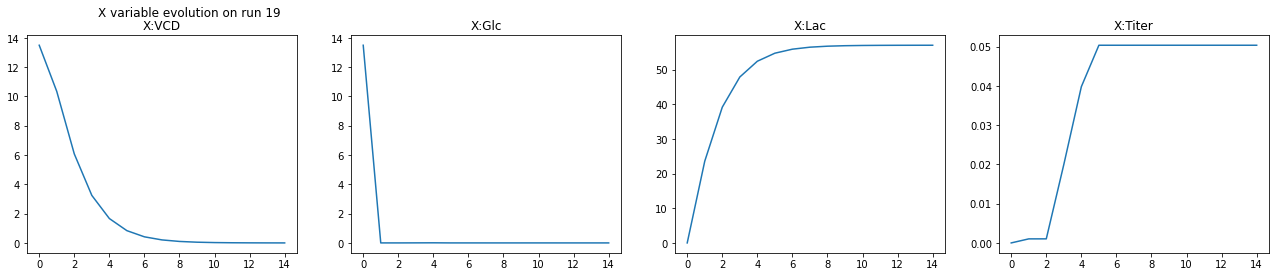

In [28]:
from matplotlib import pyplot as plt

#[print(run) for ix,run in owu.groupby("run")]
columns = list(owu.columns)
num_vars=len(columns)


for run_ix,run in owu.groupby("run"):
    fig, axs = plt.subplots(1,num_vars)
    fig.suptitle(f'X variable evolution on run {run_ix}')
    for plot_ix, col in enumerate(columns):
        axs[ plot_ix].plot(run.index.get_level_values("timestamps"),list(run[col].values))
        axs[ plot_ix].set_title(f'{col}')
        plt.subplots_adjust(right=3)

Now, to visualise the daa in another way, the data of all runs will be shown in a single graph

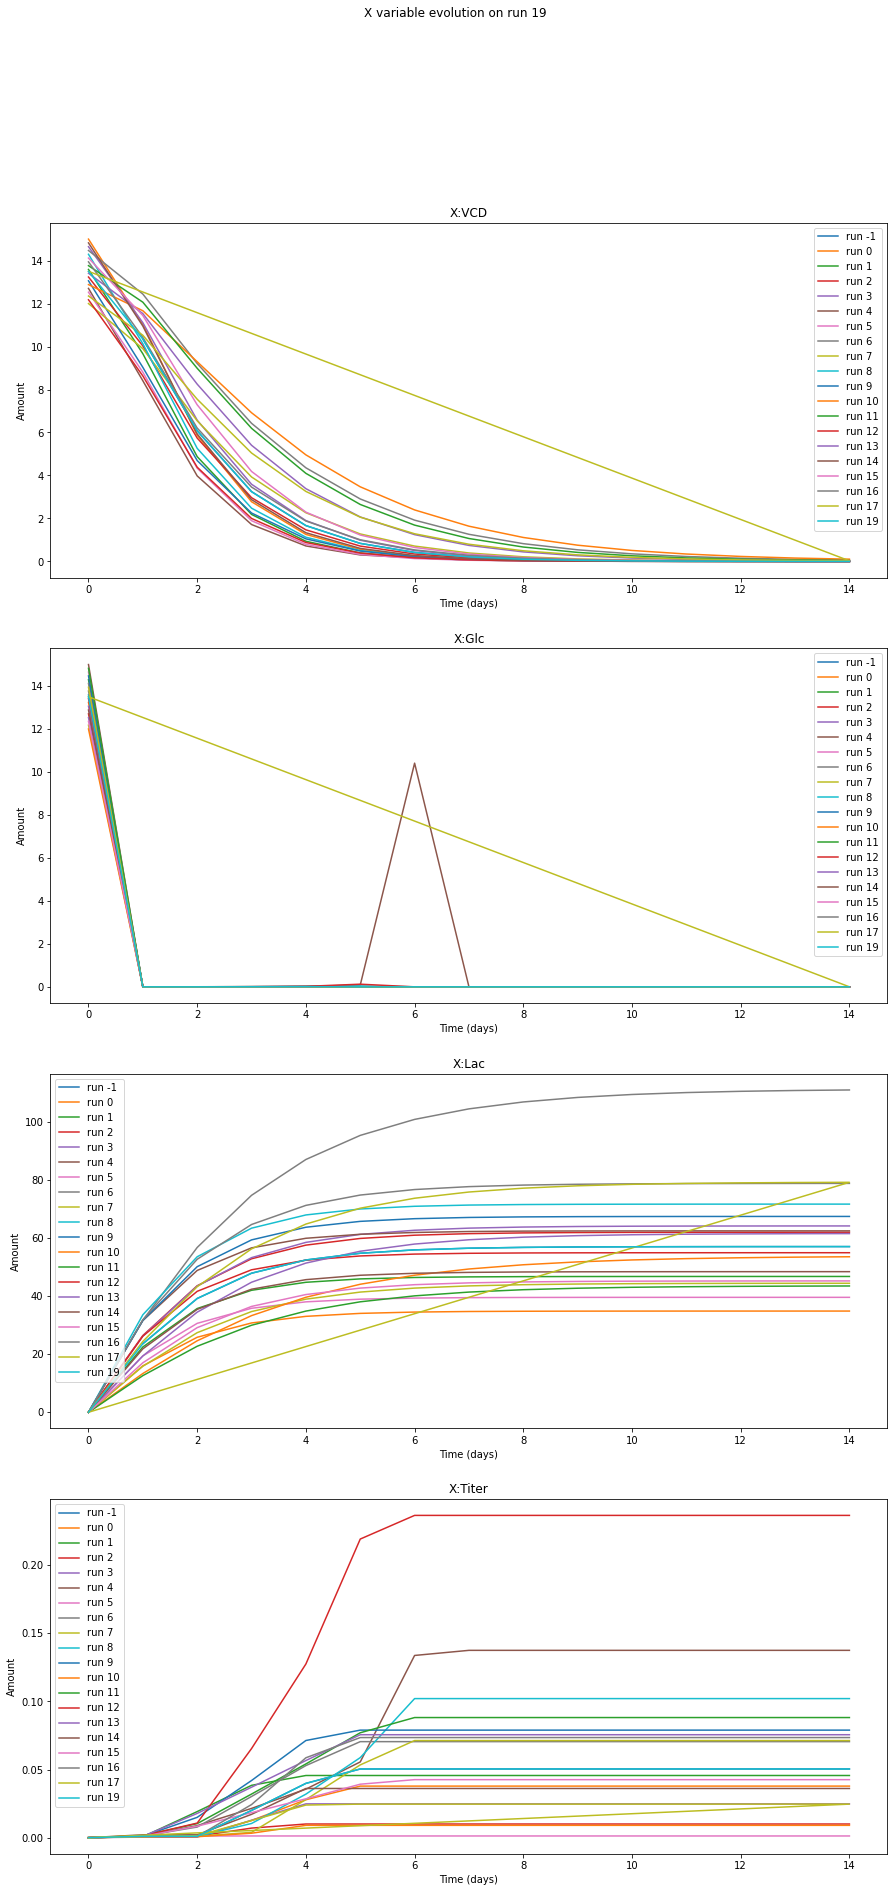

In [29]:
fig, axs = plt.subplots(num_vars,figsize=(15,30))
units_list =[""]
for run_ix,run in owu.groupby("run"):
    fig.suptitle(f'X variable evolution on run {run_ix}')
    for plot_ix, col in enumerate(columns):
        axs[ plot_ix].plot(run.index.get_level_values("timestamps"),list(run[col].values),label=f'run {run_ix}')
        axs[ plot_ix].set_title(f'{col}')
        #plt.subplots_adjust(right=3)
        axs[ plot_ix].set_xlabel("Time (days)")
        axs[ plot_ix].set_ylabel("Amount")
        axs[plot_ix].legend(loc="best")


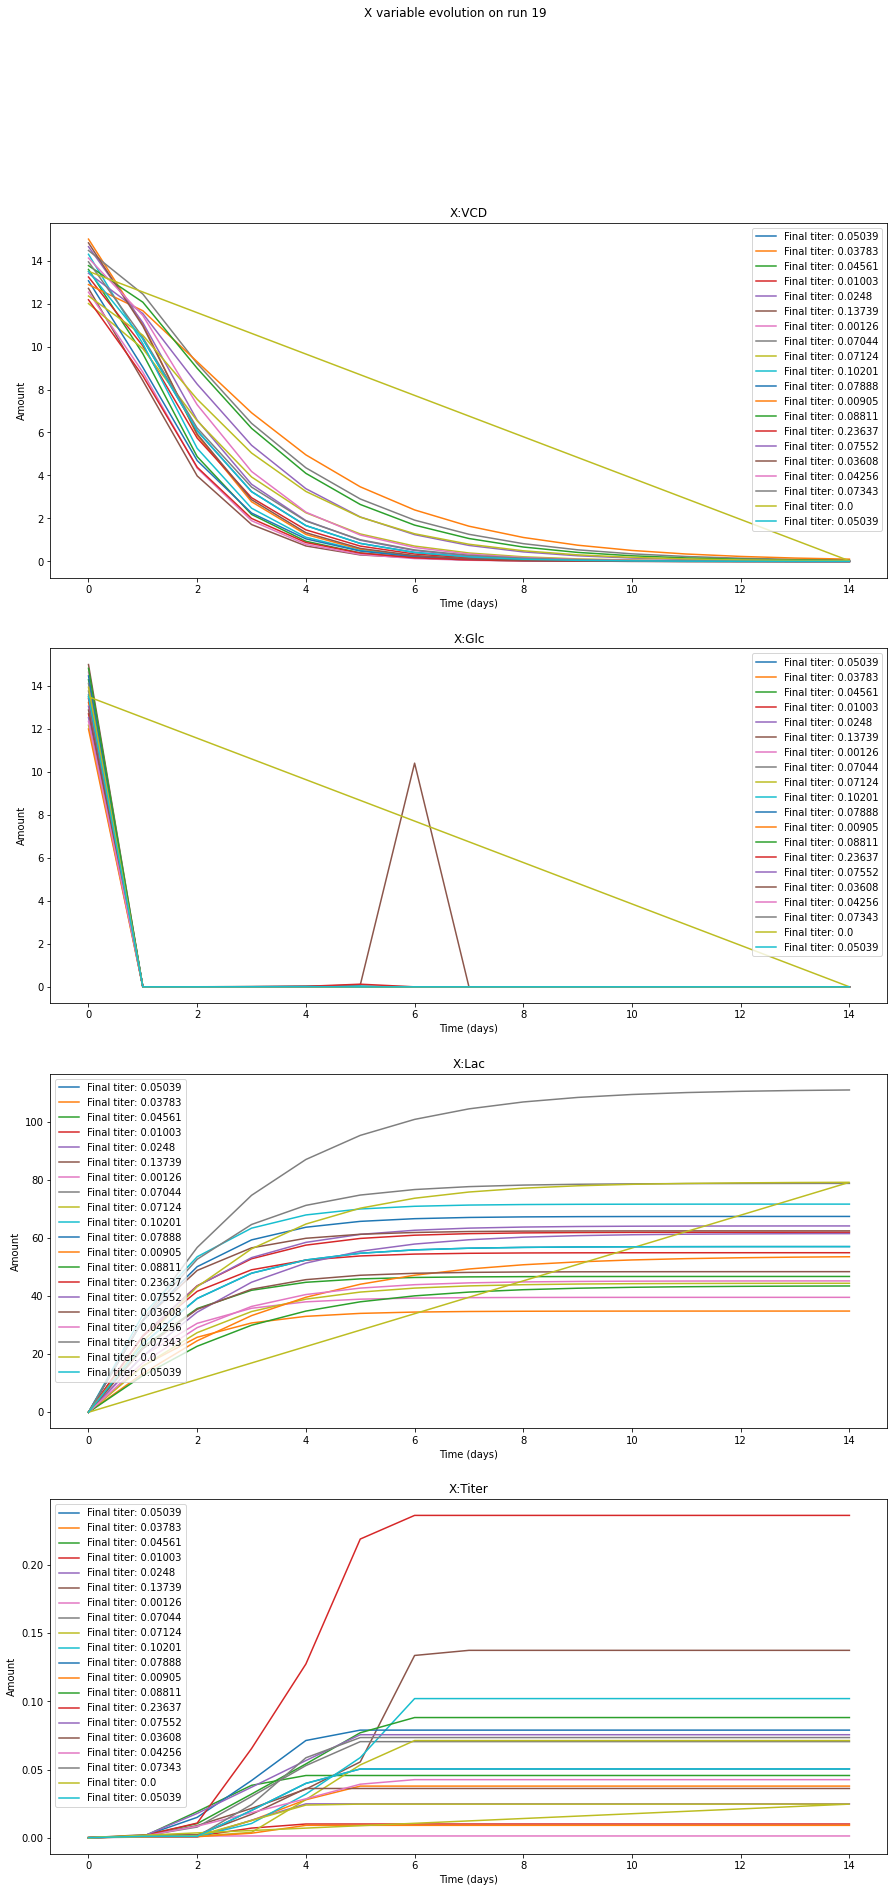

In [38]:
fig, axs = plt.subplots(num_vars,figsize=(15,30))
units_list =[""]
for run_ix,run in owu.groupby("run"):
    fig.suptitle(f'X variable evolution on run {run_ix}')
    for plot_ix, col in enumerate(columns):
        axs[ plot_ix].plot(run.index.get_level_values("timestamps"),list(run[col].values),label=f'Final titer: {round(run["X:Titer"].iloc[-1],5)}')
        axs[ plot_ix].set_title(f'{col}')
        #plt.subplots_adjust(right=3)
        axs[ plot_ix].set_xlabel("Time (days)")
        axs[ plot_ix].set_ylabel("Amount")
        axs[plot_ix].legend(loc="best")


## PCA Analysis of the OWU Matrix

Beyond just visualisation, the OWU matrix can also be utilised to plot the degree of correlation between the different variables. For instance, below, the correlation matrix of our variables will be shown

In [ ]:
owu.corr()

### PCA on "unnormalised" data

Here, PCA will be applied to the data before any normalisation is applied

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components = 4)
pca.fit(owu)
expl_var = pca.explained_variance_
expl_var_ratio_ = pca.explained_variance_ratio_
expl_var

In [ ]:
import numpy as np

cum_sum_exp = np.cumsum(expl_var_ratio_)
plt.bar(range(0,len(expl_var_ratio_)), expl_var_ratio_, alpha=0.5, align='center', label='Individual explained variance')
#plt.step(range(0,len(expl_var_ratio_)), expl_var_ratio_, where='mid',label='Cumulative explained variance')
plt.plot(range(0,len(expl_var_ratio_)), 1-expl_var_ratio_,"ro-",label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.legend(loc='best')
plt.show()

### Normalised PCA

Now, PCA will be ran on normalised data

In [ ]:
from sklearn.preprocessing import StandardScaler

data_scaler = StandardScaler()

scaled_data = data_scaler.fit_transform(owu)
scaled_data

In [ ]:
pca.fit(scaled_data)
expl_var_scaled = pca.explained_variance_
expl_var_ratio_scaled = pca.explained_variance_ratio_
expl_var_scaled

cum_sum_exp = np.cumsum(expl_var_ratio_scaled)
plt.bar(range(0,len(expl_var_ratio_scaled)), expl_var_ratio_scaled, alpha=0.5, align='center', label='Individual explained variance')
plt.plot(range(0,len(expl_var_ratio_scaled)), 1-expl_var_ratio_scaled,"ro-",label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.legend(loc='best')
plt.show()

In [ ]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley,s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
pca_data = pca.fit_transform(scaled_data)
myplot(pca_data[:,0:2],np.transpose(pca.components_[0:2, :]),list(owu.columns))